In [1]:
# link of data : https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

### Import all the libraries

In [40]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold,mutual_info_regression,SelectKBest,chi2
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score,mean_absolute_error,mean_absolute_percentage_error,r2_score,mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns

In [3]:
df=pd.read_csv('train.csv')
df.drop('Id',axis=1,inplace=True)

### Target variable asign

In [4]:
y='SalePrice'  #@param {type :"string"}

In [5]:
df.shape

(1460, 80)

### Drop the columns which contain high percentage of  NAN values we can set threshold that how much precentage of values we need. This percentage_of_values_in_column takes non NAN values percentage.

In [6]:
percentage_of_values_in_column = 95 #@param {type:"integer"}
df2=df.dropna(thresh=len(df)*percentage_of_values_in_column/100,axis=1)

In [7]:
df3=df2.dropna()

### For categorical columns Label Encoding is Done.
source for lable encoding :https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [8]:
df4=df3.copy()
# Identify categorical features
categorical_features = df4.select_dtypes(include=['object']).columns

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to categorical features
for feature in categorical_features:
    df4[feature] = label_encoder.fit_transform(df4[feature])

# Print the encoded dataframe
# print(df4)

### CHI2 Test check the correlation between categorical columns and give p and f score. if p is greater  then 0.05 then it will drop column.
source for chi2 :https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html


In [9]:
f_p_values=chi2(df4[categorical_features],df4[y]) # first value in f-score and second value is p

In [10]:
p_values=pd.Series(f_p_values[1])
p_values.index = df4[categorical_features].columns

In [11]:
less_p_value =p_values[p_values >= 0.05].index.to_list()

In [12]:
df5=df4.drop(less_p_value,axis=1)

### To eliminate columns with constant or low variance values, we can utilize the Variance Threshold technique. This approach allows us to specify the desired level of variance that determines which features to drop.
source for variance threshold :https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold


In [13]:
threshold = 1.8 #@param {type:"number"}
df_vth=VarianceThreshold(threshold=threshold)

In [14]:
df_vth.fit(df5)

VarianceThreshold(threshold=1.8)

In [15]:
constant_columns = [col for col in df5.columns if col not in df5.columns[df_vth.get_support()]]

In [16]:
constant_columns=[col for col in constant_columns if df5[col].dtype != 'Object']

In [17]:
df6=df5.drop(constant_columns,axis=1)

<Axes: >

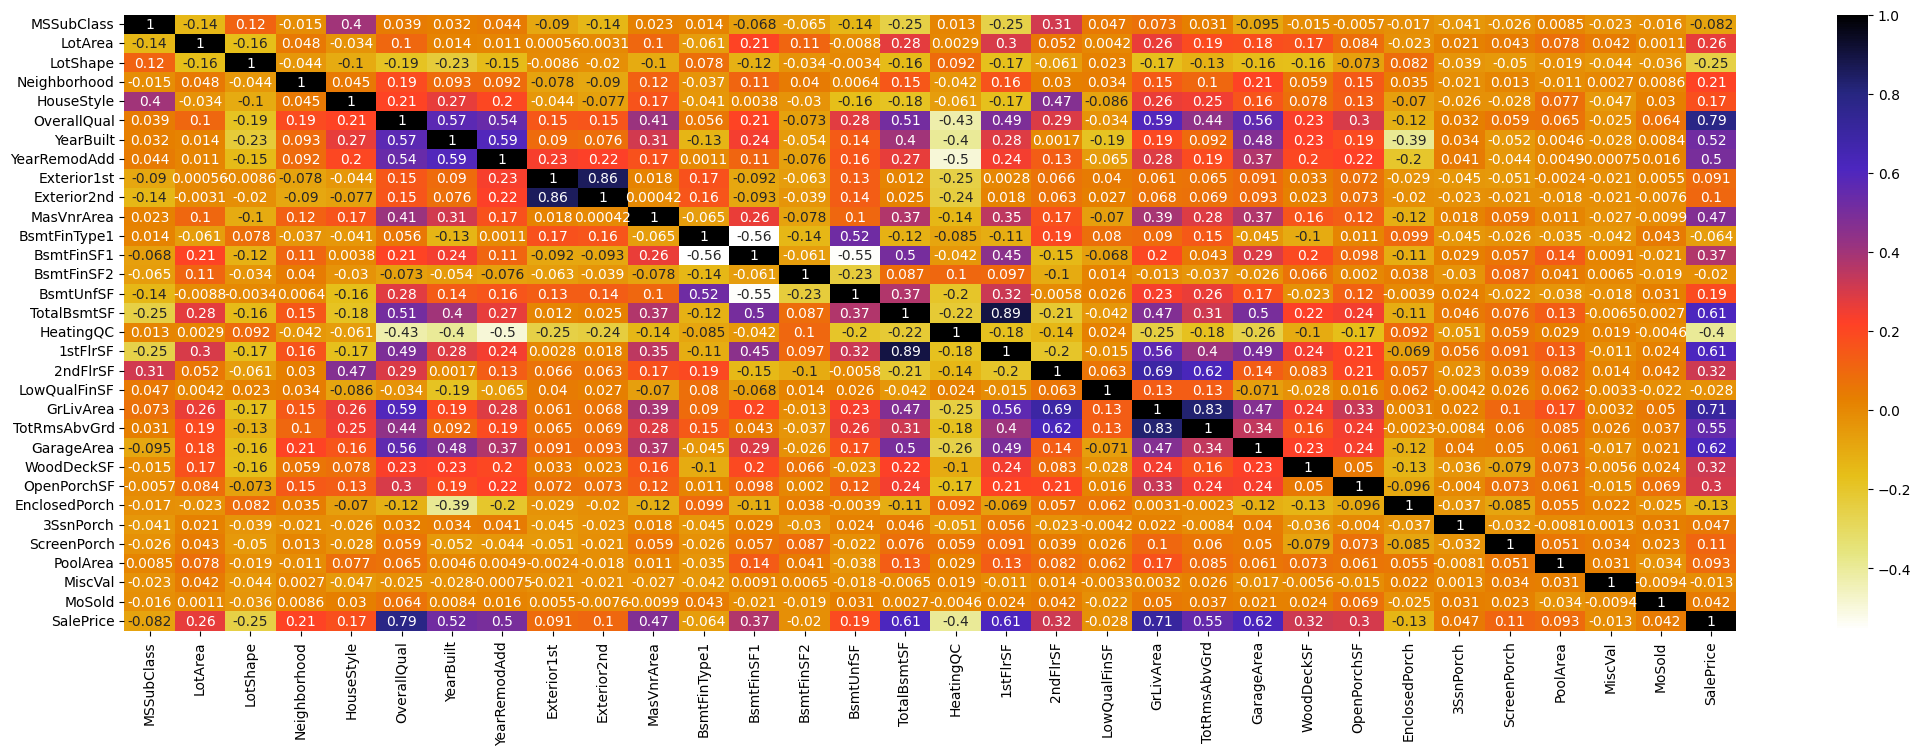

In [18]:
plt.figure(figsize=(26,8))
sns.heatmap(df6.corr(),annot=True,cmap=plt.cm.CMRmap_r) # good visualisation

### By comparing each column with one another, this function identifies and removes columns exhibiting multicollinearity. It is possible to define a threshold that determines the desired level of correlation between two columns. The input for this function is a data frame and threshold value.

In [19]:
def correlation(df,threshold):
  col_corr = set()
  corr_matrix=df.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if (corr_matrix.iloc[i,j]) > threshold:
        colname=corr_matrix.columns[i]
        col_corr.add(colname)
  return col_corr





In [20]:
cor_f=correlation(df6.drop(y,axis=1),0.8)

In [21]:
df7=df6.drop(cor_f,axis=1)

### The feature selection process utilizing mutual information involves two parameters: a dataframe (excluding the target column) and the target column itself. This approach determines the relative importance of each column and assigns an order based on their significance.
source for mutual information : https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression

In [22]:
mutual_info=mutual_info_regression(df7.drop('SalePrice',axis=1),df7.SalePrice)

In [23]:
mutual_info=pd.Series(mutual_info)
mutual_info.index=df7.columns[:-1]

<Axes: title={'center': 'Bar plot for Feature Importance'}, xlabel='Features', ylabel='Importance'>

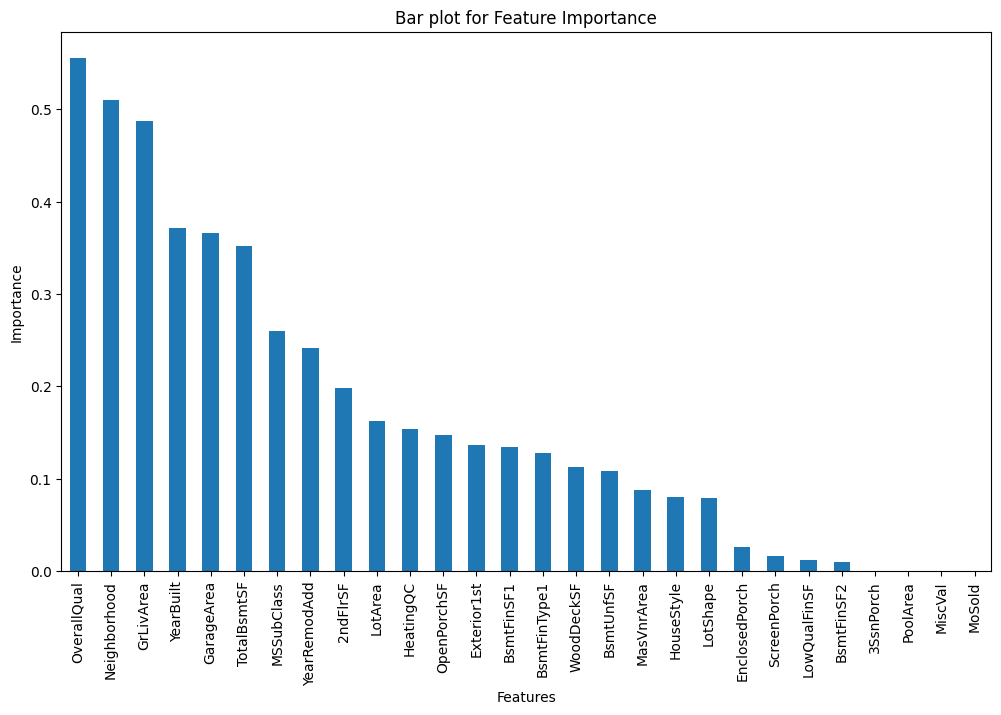

In [24]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(12,7),xlabel='Features',ylabel='Importance',title='Bar plot for Feature Importance')

### Set the Importance order you want

In [25]:
imp_order = 0.25 #@param {type:"number"}
df8=df7.drop(mutual_info[mutual_info == imp_order ].index.to_list(),axis=1)

### The task of selecting the best columns for modeling involves two parameters: a dataframe that includes feature importance values and the number of columns to be chosen based on their feature importance (represented as K).
source for SelectKBest :https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest

In [26]:
k= 16 #@param {type :"integer"}
sel_col=SelectKBest(mutual_info_regression,k=k)
sel_col.fit(df8.drop('SalePrice',axis=1),df8.SalePrice)


SelectKBest(k=16,
            score_func=<function mutual_info_regression at 0x7f1a7c702560>)

In [27]:
selected_indices = sel_col.get_support(indices=True)


In [28]:
X_selected = df8.iloc[:, selected_indices]


In [29]:
X_selected[y]=df8[y]

<ipython-input-29-2b85329bf40f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected[y]=df8[y]


In [30]:
X_selected.reset_index(inplace=True,drop=True)

In [33]:

X = X_selected.drop('SalePrice', axis=1)
y_ = X_selected['SalePrice']

X_train,X_test,y_train,y_test=train_test_split(X,y_,test_size=0.25,random_state=22)


In [34]:
model=LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
mean_absolute_percentage_error(y_test,y_pred)

0.11795996466992181

In [ ]:
mean_absolute_error(y_test,y_pred)

19438.92430986192

In [ ]:
r2_score(y_test,y_pred)

0.8422456117291671

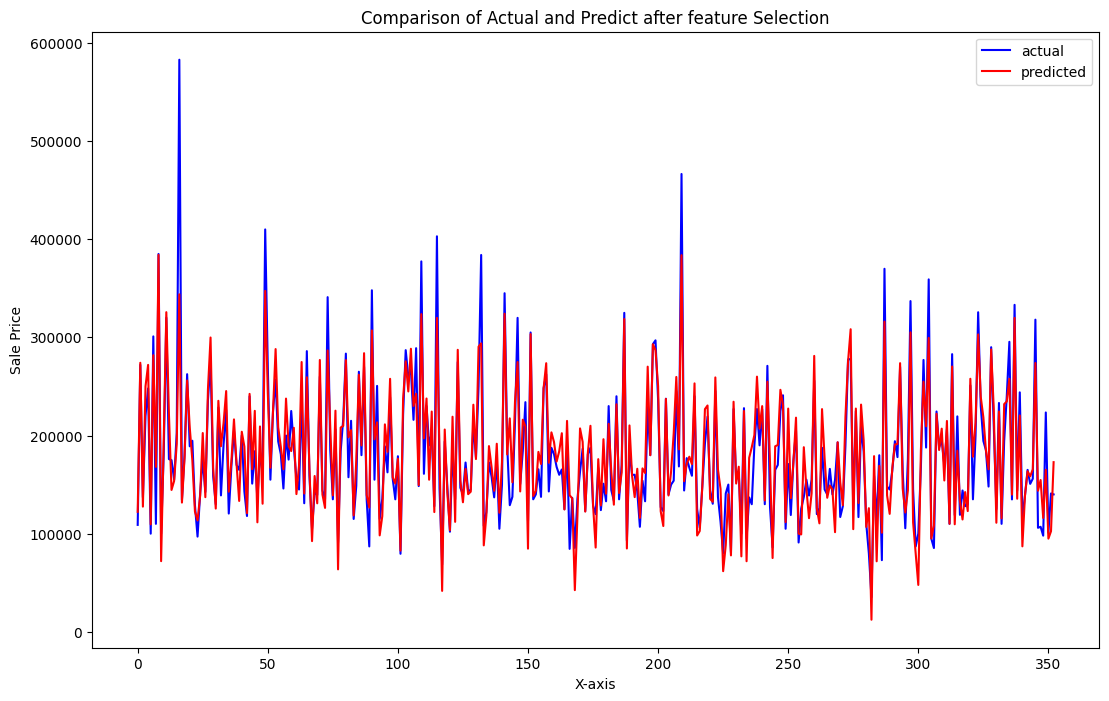

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(13,8))

# Plot list1
ax.plot(range(0,len(y_test)),y_test, label='actual',color='blue')

# Plot list2
ax.plot(range(0,len(y_test)),y_pred, label='predicted',color='red')
# ax.set_xlim([90,200])
# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Sale Price')
ax.set_title('Comparison of Actual and Predict after feature Selection')
# Add legend
ax.legend()

In [ ]:
df_=df.copy()
# Identify categorical features
categorical_features = df_.select_dtypes(include=['object']).columns

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to categorical features
for feature in categorical_features:
    df_[feature] = label_encoder.fit_transform(df_[feature])

In [ ]:
df_.dropna(inplace=True)
X = df_.drop('SalePrice', axis=1)
y_ = df_['SalePrice']

X_train,X_test,y_train,y_test=train_test_split(X,y_,test_size=0.25,random_state=22)

In [ ]:
model=LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
mean_absolute_percentage_error(y_test,y_pred)

0.12105557879722234

In [ ]:
mean_absolute_error(y_test,y_pred)

22761.865576448243

In [ ]:
r2_score(y_test,y_pred)

0.7756815228626112

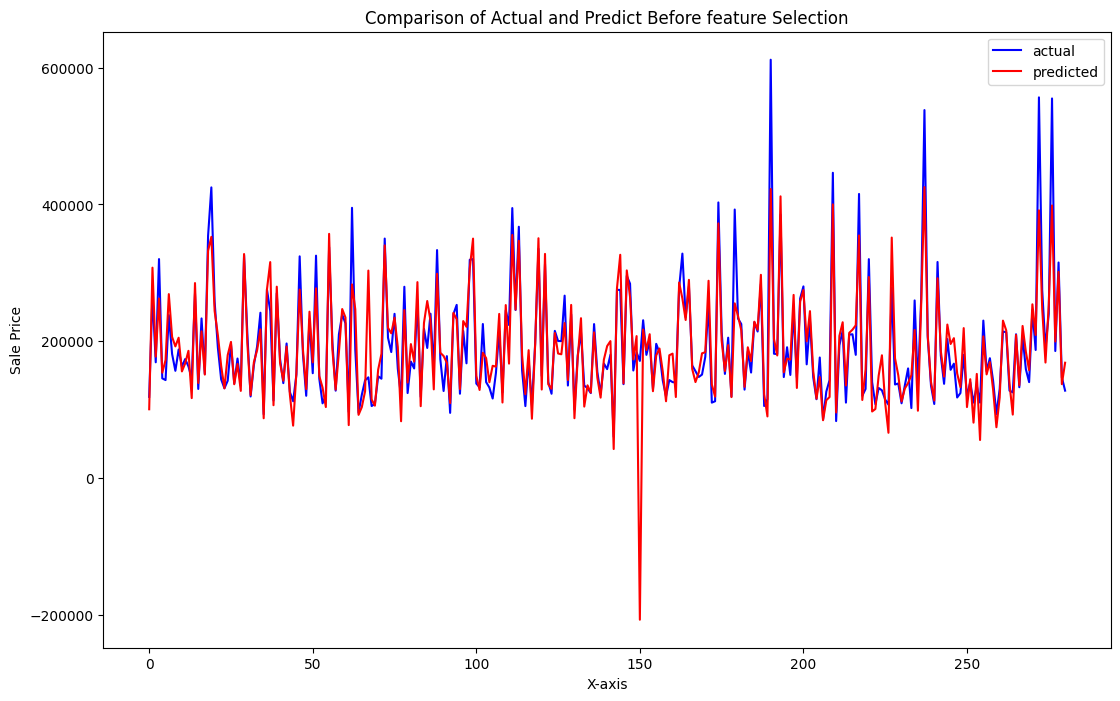

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(13,8))

# Plot list1
ax.plot(range(0,len(y_test)),y_test, label='actual',color='blue')

# Plot list2
ax.plot(range(0,len(y_test)),y_pred, label='predicted',color='red')
# ax.set_xlim([90,200])
# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Sale Price')
ax.set_title('Comparison of Actual and Predict Before feature Selection')
# Add legend
ax.legend()

### To determine feature importance using the ExtraTreeClassifier, you need to provide two parameters: a dataframe containing the features and the target variable. The algorithm will then assign rankings to the features based on their importance.
source for Extra Tree Classifier :https://scikit-learn.org/stable/modules/generated/sklearn.tree.ExtraTreeClassifier.html#sklearn-tree-extratreeclassifier







In [ ]:
from sklearn.tree import ExtraTreeClassifier
model=ExtraTreeClassifier()
model.fit(df8.drop(y,axis=1),df8[y])

ExtraTreeClassifier()

In [ ]:
rank_f=pd.Series(model.feature_importances_,index=df8.columns[:-1]) # higher the value of feature_importances more important will be the feature

<Axes: >

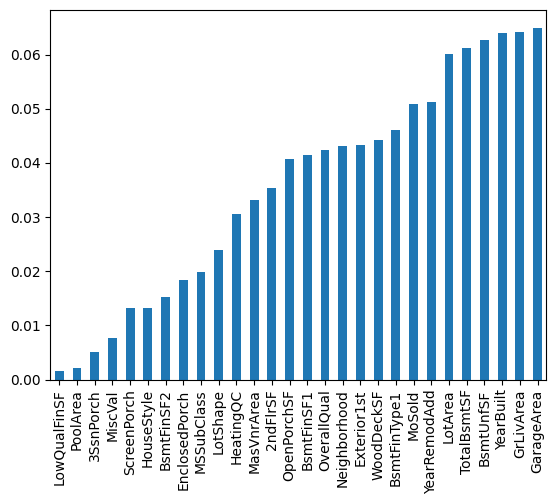

In [ ]:
rank_f.sort_values().plot(kind='bar')

In [ ]:
thre = 0 #@param {type:"number"}
constant_f=rank_f[rank_f <thre].index.to_list()
df9=df8.drop(constant_f,axis=1)


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df9.drop(y,axis=1),df9[y],test_size=0.25,random_state=42)

In [ ]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)


DecisionTreeRegressor()

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
mean_absolute_error(y_test,y_pred)

26038.175637393768

In [ ]:
r2_score(y_test,y_pred)

0.7464433813484672

In [ ]:
mean_absolute_percentage_error(y_test,y_pred)

0.16080640178889205

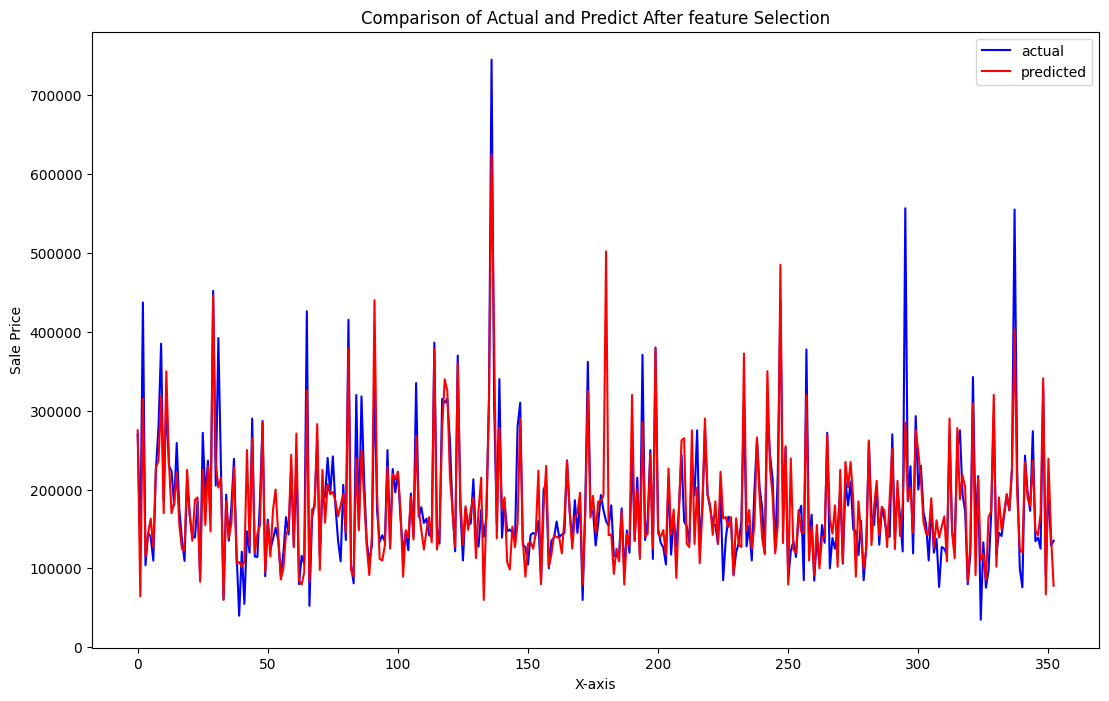

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(13,8))

# Plot list1
ax.plot(range(0,len(y_test)),y_test, label='actual',color='blue')

# Plot list2
ax.plot(range(0,len(y_pred)),y_pred, label='predicted',color='red')
# ax.set_xlim([90,95])
# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Sale Price')
ax.set_title('Comparison of Actual and Predict After feature Selection')
# Add legend
ax.legend()

In [ ]:
df_.dropna(inplace=True)
X = df_.drop('SalePrice', axis=1)
y_ = df_['SalePrice']

X_train,X_test,y_train,y_test=train_test_split(X,y_,test_size=0.25,random_state=22)

In [ ]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
mean_absolute_error(y_test,y_pred)

29091.612099644128

In [ ]:
r2_score(y_test,y_pred)


0.7273038867686465

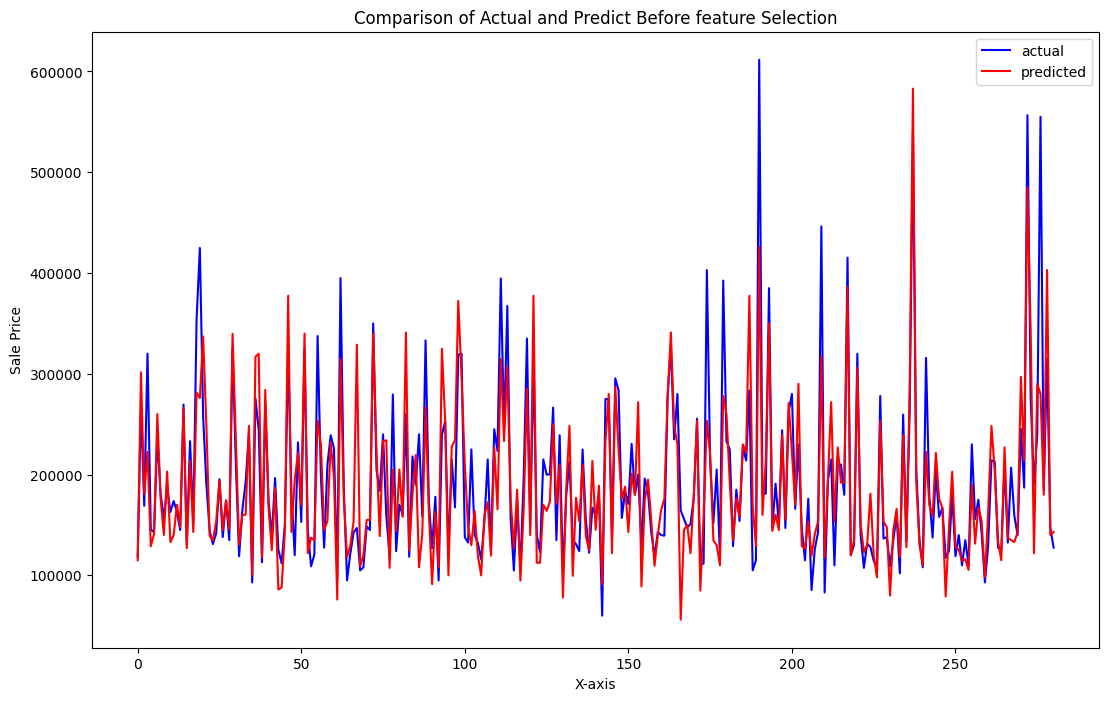

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(13,8))

# Plot list1
ax.plot(range(0,len(y_test)),y_test, label='actual',color='blue')

# Plot list2
ax.plot(range(0,len(y_pred)),y_pred, label='predicted',color='red')
# ax.set_xlim([90,95])
# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Sale Price')
ax.set_title('Comparison of Actual and Predict Before feature Selection')
# Add legend
ax.legend()

In [ ]:
len(y_pred)

281

### Principal component Analysis

source for PCA : https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html



In [38]:
scaler=StandardScaler()
scaler.fit(df4)
scaled_data=scaler.transform(df4)


In [96]:
n_components = 20 #@param {type:"number"}
pca=PCA(n_components=n_components)
data_pca=pca.fit_transform(scaled_data[:,:-1])


In [97]:

X_train,X_test,y_train,y_test=train_test_split(data_pca,scaled_data[:,-1],test_size=0.25,random_state=22)

In [98]:
model=LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [99]:
y_pred=model.predict(X_test)

In [100]:
mean_absolute_error(y_test,y_pred)

0.24300170365299162

In [101]:
r2_score(y_test,y_pred)

0.8507301746338507

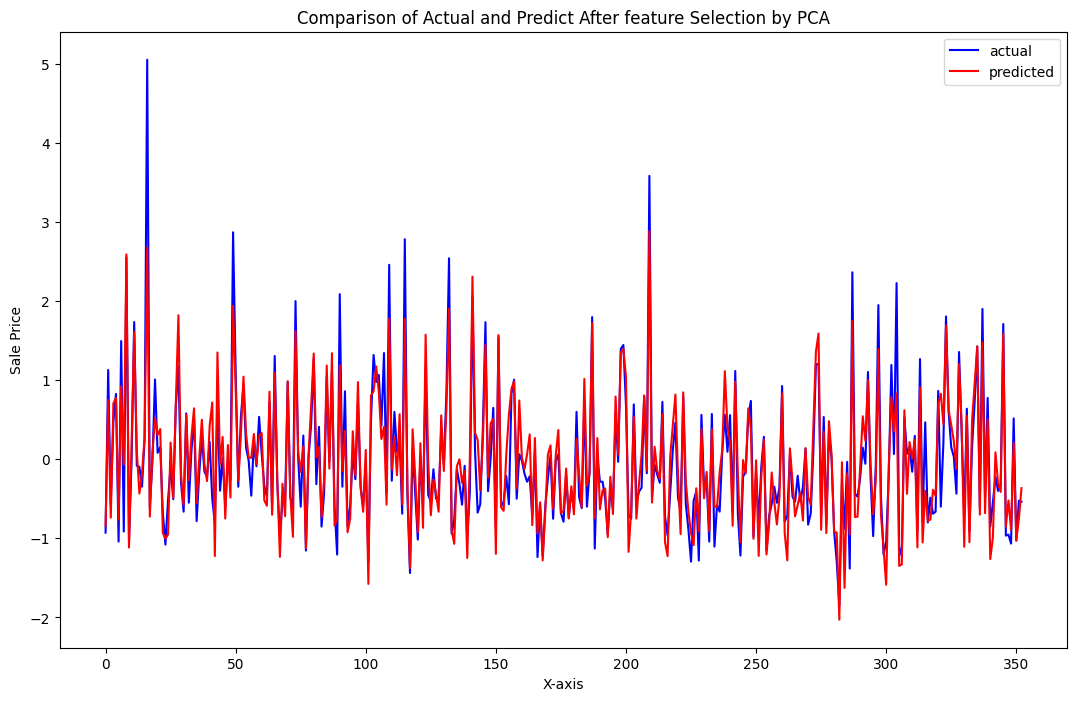

In [102]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(13,8))

# Plot list1
ax.plot(range(0,len(y_test)),y_test, label='actual',color='blue')

# Plot list2
ax.plot(range(0,len(y_pred)),y_pred, label='predicted',color='red')
# ax.set_xlim([90,95])
# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Sale Price')
ax.set_title('Comparison of Actual and Predict After feature Selection by PCA')
# Add legend
ax.legend()

In [ ]:
def correlation(df,threshold):
  col_corr = set()
  corr_matrix=df.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if (corr_matrix.iloc[i,j]) > threshold:
        colname=corr_matrix.columns[i]
        col_corr.add(colname)
  return col_corr
def feature_selection(df,target_column):
  y=target_column
  percentage_of_values_in_column = 95 #@param {type:"integer"}
  df2=df.dropna(thresh=len(df)*percentage_of_values_in_column/100,axis=1)
  df3=df2.dropna()
  df4=df3.copy()
  # Identify categorical features
  categorical_features = df4.select_dtypes(include=['object']).columns

  # Initialize LabelEncoder
  label_encoder = LabelEncoder()

  # Apply label encoding to categorical features
  for feature in categorical_features:
      df4[feature] = label_encoder.fit_transform(df4[feature])
  f_p_values=chi2(df4[categorical_features],df4[y])
  p_values=pd.Series(f_p_values[1])
  p_values.index = df4[categorical_features].columns
  less_p_value =p_values[p_values >= 0.05].index.to_list()
  df5=df4.drop(less_p_value,axis=1)
  threshold = 1.8 #@param {type:"number"}
  df_vth=VarianceThreshold(threshold=threshold)
  df_vth.fit(df5)
  constant_columns = [col for col in df5.columns if col not in df5.columns[df_vth.get_support()]]
  constant_columns=[col for col in constant_columns if df5[col].dtype != 'Object']
  df6=df5.drop(constant_columns,axis=1)
  cor_f=correlation(df6.drop(y,axis=1),0.8)
  df7=df6.drop(cor_f,axis=1)
  mutual_info=mutual_info_regression(df7.drop('SalePrice',axis=1),df7.SalePrice)
  mutual_info=pd.Series(mutual_info)
  mutual_info.index=df7.columns[:-1]
  mutual_info.sort_values(ascending=False).plot.bar(figsize=(12,7),xlabel='Features',ylabel='Importance',title='Bar plot for Feature Importance')
  imp_order = 0.25 #@param {type:"number"}
  df8=df7.drop(mutual_info[mutual_info == imp_order ].index.to_list(),axis=1)


